# EODP A2 #

## Research Question ##
Given the versatility of the film and TV features over time, how does the key features of a media influence the viewership and ratings of films and TV shows?

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

# pip install wordcloud
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Number of Movies Over Time #

In [16]:
#load csv
dataAsDF = pd.read_csv('titles.csv')

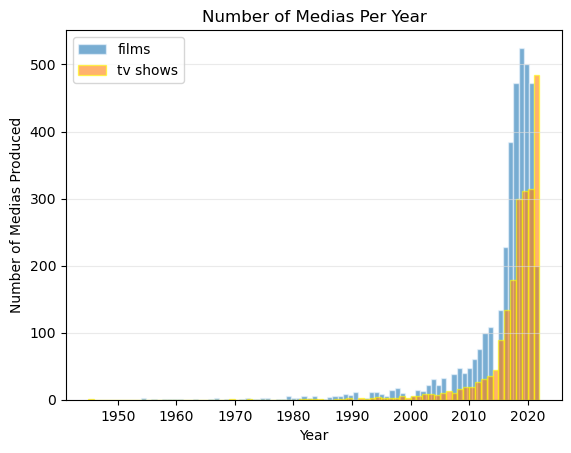

In [17]:
mediaData = dataAsDF.copy()

# Plot number of medias per year
def plotNbMediasPerYearHistogram(mediaData, outputFileName): 
    # ax = mediaData['release_year'].hist(bins = max(mediaData['release_year']) - min(mediaData['release_year']))
    plt.xlabel('Year')
    plt.ylabel('Number of Medias Produced')
    plt.title('Number of Medias Per Year')
    plt.grid(axis = 'y', color = 'gainsboro', alpha = 0.6)

    bins = max(mediaData['release_year']) - min(mediaData['release_year'])
    filmData = mediaData[mediaData['type'] == 'MOVIE']
    tvShowData = mediaData[mediaData['type'] == 'SHOW']

    # plotting first histogram: films
    plt.hist(filmData['release_year'], label='films', bins=bins, alpha=0.6, edgecolor='aliceblue')
    
    # plotting second histogram: tv shows
    plt.hist(tvShowData['release_year'], label="tv shows", bins=bins, alpha=0.6, edgecolor='yellow')
    
    plt.legend()

    plt.savefig(outputFileName)

plotNbMediasPerYearHistogram(mediaData, 'NumberOfMediasPerYearHistogram')

# Analysis Per Decade #

In [18]:
mediaDataWithDecade = mediaData.copy()
#create a release_decade column where rounds release_years to their decade
mediaDataWithDecade['release_decade'] = mediaDataWithDecade['release_year'].floordiv(10).multiply(10)

# Films and TV SHows' Titles #

## Missing Title Values ##

In [19]:
missing_values = mediaDataWithDecade.isna().sum()
print(missing_values)

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
release_decade             0
dtype: int64


In [20]:
# there was one title value missing, needs to be dropped
mediaDataWithDecade = mediaDataWithDecade.dropna(subset=['title'])
mediaDataWithDecade

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,release_decade
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN,1940
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,1970
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,1970
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,1970
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN,2020
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,['drama'],[],NaN,tt11803618,7.7,348.0,NaN,NaN,2020
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,['comedy'],['CO'],NaN,tt14585902,3.8,68.0,26.005,6.300,2020
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],['US'],NaN,NaN,NaN,NaN,1.296,10.000,2020


## Title Preprocessing ##

In [21]:
# Instantiating the lemmatiser algorithm 
lemmatizer = WordNetLemmatizer() 

# Preprocess each text, such as film title
def text_preprocess_with_punct(title):
    
    # case-folding
    lowercased_title = str(title).lower()
    
    # noise reduction
    #no_apostrophe_title = re.sub(r'([A-Za-z0-9_À-ÿ]+)[\'][s]', r'\1', lowercased_title)
    no_punct_at_word_end_title = re.sub(r'([A-Za-z0-9_À-ÿ]+)[^A-Za-z0-9À-ÿ]+[\s]+', r'\1 ', lowercased_title)
    no_punct_at_end_title = re.sub(r'[^A-Za-z0-9À-ÿ]+$', '', no_punct_at_word_end_title)
    no_punct_at_word_start_title = re.sub(r'[\s]+[^A-Za-z0-9À-ÿ]+([A-Za-z0-9_À-ÿ]+)', r' \1', no_punct_at_end_title)
    no_punct_at_start_title = re.sub(r'^[^A-Za-z0-9À-ÿ]+', '', no_punct_at_word_start_title)
    no_punct_in_spaces_title = re.sub(r'\s+[^A-Za-z0-9_À-ÿ]+\s+', ' ', no_punct_at_start_title)
    cleaned_title = re.sub(r'\s+', ' ', no_punct_in_spaces_title) # regard words connected by hyphen as one word

    # tokenize the titles by space, to keep as much information within the words as possible
    tokens_title = cleaned_title.split(' ')
    
    # lemmitization
    lemmatized_tokens_title = [lemmatizer.lemmatize(w) for w in tokens_title] 
    
    return lemmatized_tokens_title

def preprocessDFColumn(df, columnName, resultColumnName):
    df[resultColumnName] = df[columnName].apply(text_preprocess_with_punct)

mediaDataWithDecadeAndTitleTokens = mediaDataWithDecade.copy()
# Preprocess the media titles
preprocessDFColumn(mediaDataWithDecadeAndTitleTokens, 'title', 'titleWords')
mediaDataWithDecadeAndTitleTokens

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,release_decade,titleWords
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN,1940,"[five, came, back, the, reference, film]"
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,1970,"[taxi, driver]"
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,1970,[deliverance]
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,1970,"[monty, python, and, the, holy, grail]"
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1960,"[the, dirty, dozen]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN,2020,"[fine, wine]"
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,['drama'],[],NaN,tt11803618,7.7,348.0,NaN,NaN,2020,"[c/o, kaadhal]"
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,['comedy'],['CO'],NaN,tt14585902,3.8,68.0,26.005,6.300,2020,[lokillo]
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],['US'],NaN,NaN,NaN,NaN,1.296,10.000,2020,"[dad, stop, embarrassing, me, the, afterparty]"


## General Idea of Words in Titles Through Time ##

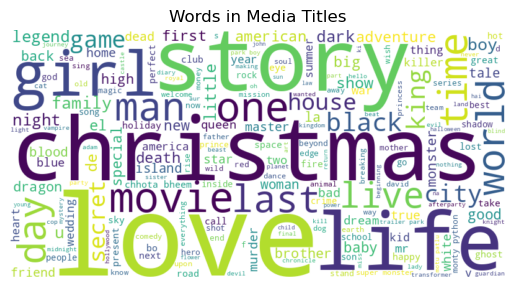

In [22]:
from itertools import chain
def drawGeneralWordCloud(mediaDataWithTitleTokens, outputFileName):
    wordCloud = WordCloud(width=800, height=400, background_color='white')
    wordCloud.generate(' '.join(chain.from_iterable(mediaDataWithTitleTokens['titleWords'])))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title("Words in Media Titles")
    plt.axis("off")
    plt.savefig(outputFileName)
drawGeneralWordCloud(mediaDataWithDecadeAndTitleTokens, "MediaTitleWordsWordCloud")

## BOWs of Media Titles ##

In [23]:
# Obtain bag of words of a column in df with tf scores, such as for movie titles
def getBow(df, resultTextColumnName):
    
    cleaned_texts = []
    for text in df[resultTextColumnName]:
        cleaned_text = ' '.join(text)
        cleaned_texts.append(cleaned_text)
    vectorizer = CountVectorizer(max_features = 10) # find top 10 words
    bow = vectorizer.fit_transform(cleaned_texts)
    vocabulary = vectorizer.get_feature_names_out()
    
    return bow, vocabulary

# Obtain bag of words with tf scores per release_decade of movie titles
def getBowGroupedByAFeature(df, textColumnName, resultTextColumnName, groupedByColumnName):
    #preprocessDFColumn(df, textColumnName, resultTextColumnName)
    
    # group the dataframe by decade
    grouped = df.groupby(groupedByColumnName)
    bows = []
    vocabularies = []

    # iterate over each group (each group is a decade)
    for groupIndex, group in grouped:
        bow, vocabulary = getBow(group, resultTextColumnName)
        bows.append(bow)
        vocabularies.append(vocabulary)
    
    return bows, vocabularies

filmData = mediaDataWithDecadeAndTitleTokens[mediaDataWithDecadeAndTitleTokens['type'] == 'MOVIE']
tvShowData = mediaDataWithDecadeAndTitleTokens[mediaDataWithDecadeAndTitleTokens['type'] == 'SHOW']

# get bag of words for each decade's movie titles
bowsOfFilmTitlesPerDecade, vocabulariesOfFilmTitlesPerDecade = getBowGroupedByAFeature(filmData, 'title', 'titleWords', 'release_decade')
bowsOfTvShowTitlesPerDecade, vocabulariesOfTvShowTitlesPerDecade = getBowGroupedByAFeature(tvShowData, 'title', 'titleWords', 'release_decade')

In [24]:
# compute word clouds of the most frequently appearing words
# pip install wordcloud
from wordcloud import WordCloud

#draw word clouds for each decades' top 10 most frequent words used in titles
def drawWordCloudByDecade(vocabsOfTitlesPerDecade, decades, outputFileName, mediaType):
    # Initialise the subplot function using number of rows and columns
    width = 3
    height = 3
    figure, axis = plt.subplots(width, height)
    figure.suptitle(mediaType + " Titles' Most Frequent Words by Decade")
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    NbEmptyDecade = width * height - len(vocabsOfTitlesPerDecade)

    for i in range(width * height):

        if (i*10 + 1940) not in decades:
            axis[i//width, i%width].axis("off")
            continue;

        wordCloud = WordCloud(width=800, height=400, background_color='white', stopwords = '')
        wordCloud.generate(' '.join(list(vocabsOfTitlesPerDecade[i-NbEmptyDecade])))
        axis[i//width, i%width].imshow(wordCloud, interpolation='bilinear')
        axis[i//width, i%width].set_title("Decade " + str(i*10 + 1940) + "s")
        axis[i//width, i%width].axis("off")
        axis[i//width, i%width].plot()
    plt.savefig(outputFileName)

drawWordCloudByDecade(vocabulariesOfFilmTitlesPerDecade, sorted(filmData['release_decade'].unique()), "MovieTitlesTop10WordsByDecadeWordCloud", "Movie")
drawWordCloudByDecade(vocabulariesOfTvShowTitlesPerDecade, sorted(tvShowData['release_decade'].unique()), "TvShowTitlesTop10WordsByDecadeWordCloud", "TV Show")


## Media Title Lengths Per Decade ##


### Option 1 ###

In [11]:
# Plot length of movie titles in box plot per decade
def plotMovieTitleLengthsPerDecadeBoxPlot(mediaData, outputFileName, mediaType): 
    mediaData['countTitleWords'] = mediaData['titleWords'].apply(len)
    
    titleLengthsPerDecadeBoxPlot = mediaData.boxplot(
        column = 'countTitleWords', 
        by = 'release_decade',
        medianprops = dict(linestyle='-', linewidth=4, color='r'))
    titleLengthsPerDecadeBoxPlot.set_xlabel('Decade')
    titleLengthsPerDecadeBoxPlot.set_ylabel('Title Length')
    plt.suptitle("") # get rid of automatic title
    titleLengthsPerDecadeBoxPlot.set_title(mediaType + 'Title Lengths Per Decade')
    plt.rcParams["figure.figsize"] = (15, 7) # Larger figure size
    plt.savefig(outputFileName)

    return
    
# Plot length of movie titles in box plot per decade
plotMovieTitleLengthsPerDecadeBoxPlot(filmData, "MovieTitleLengthsPerDecadeBoxPlot.png", "Movie")
plotMovieTitleLengthsPerDecadeBoxPlot(filmData, "TvShowTitleLengthsPerDecadeBoxPlot.png", "TV Show")


### Option 2 ###

In [12]:
# set colour and properties for each plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items(): # iterate through all properties of the box plot
        plt.setp(plot_name.get(k), color=color_code) # assign the colour code of the dictionary returned by each plot
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()

# input the media dataframe that has the release_decade feature
def mediaTitleLengthsPerDecadeComparisonBoxplot(mediaData, outputFileName): 
    mediaData = mediaData.sort_values('release_year') # to make sure x-values are in order
    mediaData['countTitleWords'] = mediaData['titleWords'].apply(len)
    
    # the x scale
    ticks = mediaData['release_decade'].unique()

    filmCountTitleWordsByDecade = mediaData[mediaData['type'] == 'MOVIE'].loc[:, ('countTitleWords', 'release_decade')].groupby('release_decade')
    # filmCountTitleWordsByDecade.set_index(filmCountTitleWordsByDecade.index.astype(int)).sort_index()
    filmCountTitleWordsByDecade.head(10)
    tvShowCountTitleWordsByDecade = mediaData[mediaData['type'] == 'SHOW'].loc[:, ('countTitleWords', 'release_decade')].groupby('release_decade')
    # tvShowCountTitleWordsByDecade.set_index(tvShowCountTitleWordsByDecade.index.astype(int)).sort_index()
    tvShowCountTitleWordsByDecade.head(10)

    filmCountTitleWords = filmCountTitleWordsByDecade.apply(lambda x: x['countTitleWords'].values)
    tvShowCountTitleWords = tvShowCountTitleWordsByDecade.apply(lambda x: x['countTitleWords'].values)

    filmPlot = plt.boxplot(
        filmCountTitleWords,
        positions=np.array(
            (filmData['release_decade'].unique() - min(mediaData['release_decade']))/10
        )*1-0.2,
        widths=0.3,
        medianprops = dict(linestyle='-', linewidth=4)
    )

    tvShowPlot = plt.boxplot(
        tvShowCountTitleWords,
        positions=np.array(
            (tvShowData['release_decade'].unique() - min(mediaData['release_decade']))/10
        )*1+0.2,
        widths=0.3,
        medianprops = dict(linestyle='-', linewidth=4)
    )

    # setting colors for each plot
    define_box_properties(filmPlot, 'blue', 'film')
    define_box_properties(tvShowPlot, 'orange', 'tv show')


    # set the x label positions and values
    plt.xticks(np.arange(0, len(ticks) * 1, 1), ticks)

    plt.ylabel('Title Length in Words')
    plt.xlabel('Decade')
    plt.title('MediaTitleLengthsPerDecade')
    plt.grid(axis = 'y')

    plt.savefig(outputFileName)

mediaTitleLengthsPerDecadeComparisonBoxplot(mediaDataWithDecadeAndTitleTokens, "MediaTitleLengthsPerDecadeComparisonBoxplot")

# Analysis on Genre

### Text preprocessing

In [3]:
# Read in dataset into a dataframe
df = pd.read_csv("titles.csv")

# Filter out tv shows so that you are left with only movies
df = df[df["type"] == "MOVIE"]

# Change the release year into the decade that it was released for easier analysis. (Equal width binning)
df["release_decade"] = df["release_year"].floordiv(10).multiply(10)
df = df.sort_values(by=["release_decade"])

# Filter out only relevant columns, only need genres of the movie and their scores.
genresAndRatings = df[['id','genres','imdb_id','imdb_score','tmdb_score','release_decade']]
print(genresAndRatings)

             id                                             genres  \
23     tm204541         ['action', 'drama', 'romance', 'thriller']   
31     tm358653                      ['romance', 'crime', 'drama']   
14     tm135083                       ['drama', 'crime', 'comedy']   
13      tm16479                              ['romance', 'comedy']   
22      tm19608                      ['crime', 'romance', 'drama']   
...         ...                                                ...   
4494   tm854786                                          ['drama']   
3259   tm845496                       ['documentation', 'history']   
3266   tm498803  ['action', 'comedy', 'drama', 'thriller', 'cri...   
4523   tm949905                    ['action', 'crime', 'thriller']   
5848  tm1035612                                                 []   

         imdb_id  imdb_score  tmdb_score  release_decade  
23     tt0049761         6.7       5.900            1950  
31     tt0157132         6.6       6.000 

Check for missing values

In [4]:
# Check for missing values in scores
import numpy as np
scores = genresAndRatings['imdb_score']
# Finds all the unique values in a given set and counts the number of time each value occured in that set
scores, counts = np.unique(scores, return_counts=True)

for score, count in zip(scores, counts):
    print("Score:", score, ", Count:", count)

Score: 1.5 , Count: 1
Score: 1.6 , Count: 1
Score: 1.7 , Count: 1
Score: 1.9 , Count: 1
Score: 2.0 , Count: 2
Score: 2.1 , Count: 1
Score: 2.2 , Count: 2
Score: 2.3 , Count: 3
Score: 2.5 , Count: 4
Score: 2.6 , Count: 5
Score: 2.7 , Count: 4
Score: 2.8 , Count: 3
Score: 2.9 , Count: 3
Score: 3.0 , Count: 6
Score: 3.1 , Count: 5
Score: 3.2 , Count: 8
Score: 3.3 , Count: 10
Score: 3.4 , Count: 7
Score: 3.5 , Count: 5
Score: 3.6 , Count: 9
Score: 3.7 , Count: 15
Score: 3.8 , Count: 16
Score: 3.9 , Count: 15
Score: 4.0 , Count: 14
Score: 4.1 , Count: 11
Score: 4.2 , Count: 16
Score: 4.3 , Count: 30
Score: 4.4 , Count: 32
Score: 4.5 , Count: 39
Score: 4.6 , Count: 26
Score: 4.7 , Count: 42
Score: 4.8 , Count: 40
Score: 4.9 , Count: 32
Score: 5.0 , Count: 41
Score: 5.1 , Count: 66
Score: 5.2 , Count: 68
Score: 5.3 , Count: 81
Score: 5.4 , Count: 92
Score: 5.5 , Count: 99
Score: 5.6 , Count: 91
Score: 5.7 , Count: 99
Score: 5.8 , Count: 99
Score: 5.9 , Count: 91
Score: 6.0 , Count: 85
Score: 

From above can see that there are 315 missing values for score. These are a lot of movies to miss data from so we decided to impute the average overall score into these missing values. 

There are also some missing values for genre, but as it is significantly harder to predict what genre a movie is from title alone, we figured imputing a random value there had the potential to skew the dataset.

In [5]:
# Compute the mean of the `score`
meanImdbScore = genresAndRatings['imdb_score'].mean() 
meanTmbdScore = genresAndRatings['tmdb_score'].mean() 

# Replace any missing values in scores with the mean value
genresAndRatings['imdb_score'] = genresAndRatings['imdb_score'].fillna(meanImdbScore)
genresAndRatings['tmdb_score'] = genresAndRatings['tmdb_score'].fillna(meanTmbdScore)

Special case (from domain knowledge):
We are only 1/3 of the way through 2020 decade which makes it appear like there's way less movies produced this decade. 

By multiplying the movies from 2020 by 3 this gives a better indicater of the trends for this decade while not messing up the averages.

In [6]:
# Copy the rows corresponding to the 2020's twice
copy1 = genresAndRatings[genresAndRatings['release_decade'] == 2020].copy()
copy2 = copy1.copy()

# Merge these back together with the original dataframe
genresAndRatings = pd.concat([genresAndRatings, copy1, copy2], ignore_index=True)

Reformatting of the genre column:

In [7]:
# Find all the distinct genres
genres = []
for element in df['genres']:
    # Element is a list represented as a string so need to turn it back to a list
    # Remove everything except alphabetic characters and spaces
    element = re.sub(r'[^A-Za-z\s]', '', element)
    # Split into a list based on spaces
    element = element.split()
    # Go through each genre in the list for that specific movie
    for genre in element:
        # Check if genre has been found before and append it if it hasnt
        if(genre not in genres):
            genres.append(genre)

# Seperate out each all movies in each genre
dataframes = []
for genre in genres:
    # Find all movies with that genre
    genreDF = genresAndRatings[genresAndRatings['genres'].str.contains(genre)]
    # Make the genres column only contain that genre
    genreDF['genres'] = genre
    # Add this to the list of dataframes that we're using to build the new dataframe.
    dataframes.append(genreDF)

# Combine them all into one big dataframe
moviesOneGenreDF = pd.concat(dataframes, ignore_index=True)

### Analysis of Each Genre Over Time

In [8]:
def plotGenre(genre, column):
    currDF = moviesOneGenreDF[moviesOneGenreDF['genres'] == genre]

    boxPlot = currDF.boxplot(
        column = column, 
        by = 'release_decade',
        medianprops = dict(color='r'))
    plt.suptitle('') # Remove automatic title
    boxPlot.set_xlabel('Decade')
    boxPlot.set_ylabel('Ratings')
    boxPlot.set_title(genre + " " + column + " Over Time")
    plt.savefig(genre + "_" + column + "_vs_time.png")
    plt.show()

In [19]:
plotGenre('comedy', 'imdb_score')
plotGenre('comedy', 'tmdb_score')
plotGenre('romance', 'imdb_score')
plotGenre('romance', 'tmdb_score')
plotGenre('thriller', 'imdb_score')
plotGenre('thriller', 'tmdb_score')
plotGenre('action', 'imdb_score')
plotGenre('action', 'tmdb_score')
plotGenre('crime', 'imdb_score')
plotGenre('crime', 'tmdb_score')

### Analysis of All Genres Over Time

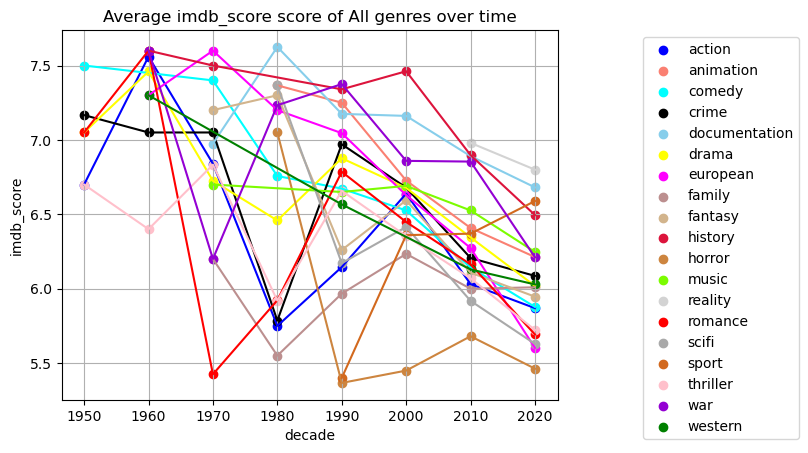

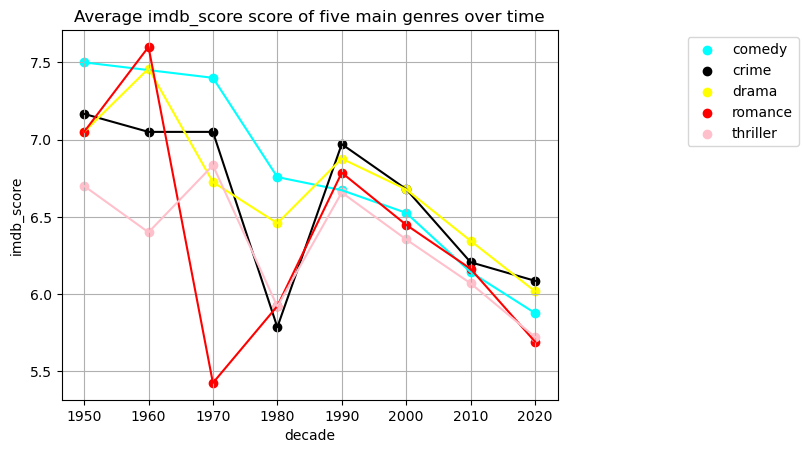

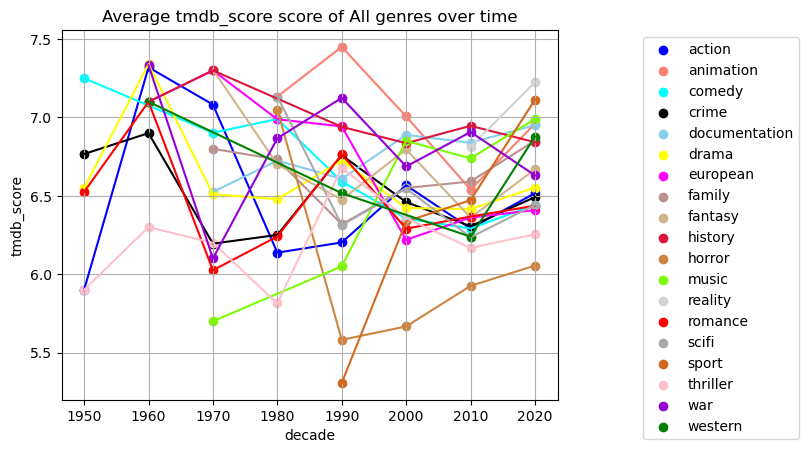

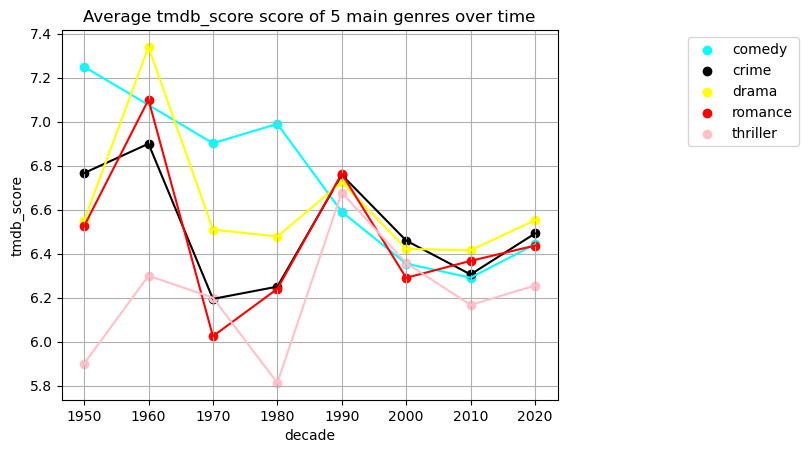

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot the scatterplot with a different colour for each genre
colormap = {'action':'blue', 'drama':'yellow', 'romance':'red', 'thriller':'pink', 'crime':'black', 'comedy':'cyan', 'western':'green', 'european':'magenta', 'war':'darkviolet', 'history':'crimson', 'documentation':'skyblue', 'music':'lawngreen', 'fantasy':'tan', 'family':'rosybrown', 'animation':'salmon', 'scifi':'darkgrey', 'horror':'peru', 'sport':'chocolate', 'reality':'lightgrey'}
tempGenres = moviesOneGenreDF[moviesOneGenreDF['genres'].isin(['comedy', 'drama', 'romance', 'crime', 'thriller'])]

def plotGenreOverTime(dataframe, column, amount):
    # Use Groupby to plot a scatter for each group, with proper color & label
    for genre, df in dataframe.groupby('genres'):
        tempDF = df.groupby('release_decade').mean(numeric_only=True)
        tempDF = tempDF.reset_index()
        plt.scatter(tempDF['release_decade'], tempDF[column],
                    label=genre, c=colormap[genre]) # Map color & label depending on the `genre`
        plt.plot(tempDF['release_decade'], tempDF[column], c=colormap[genre])
    # Set up aesthetics
    plt.grid()
    plt.xlabel('decade')
    plt.ylabel(column)
    plt.title("Average "+ column +" score of " + amount + " genres over time")
    plt.legend(bbox_to_anchor=(1.5, 1))
    plt.show()
    plt.savefig(amount + "_" + column + "_vs_time.png")

plotGenreOverTime(moviesOneGenreDF, 'imdb_score', 'All')
plotGenreOverTime(tempGenres, 'imdb_score', 'five main')
plotGenreOverTime(moviesOneGenreDF, 'tmdb_score', 'All')
plotGenreOverTime(tempGenres, 'tmdb_score', '5 main')

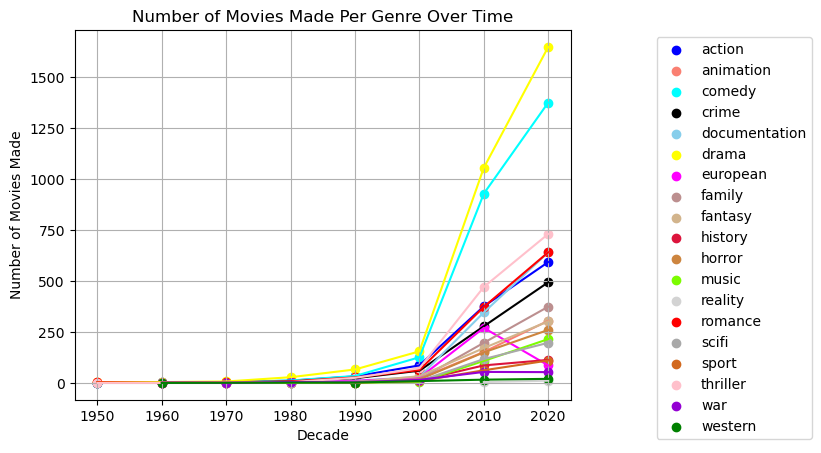

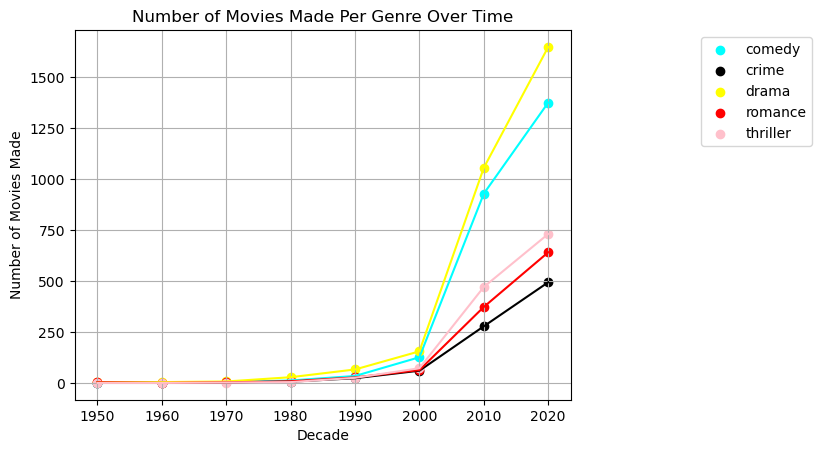

<Figure size 640x480 with 0 Axes>

In [9]:
def plotMoviesMade(dataframe, amount):
    # Use Groupby to plot a scatter for each group, with proper color & label
    for genre, df in dataframe.groupby('genres'):
        tempDF = df.groupby('release_decade').count()
        tempDF = tempDF.reset_index()
        plt.scatter(tempDF['release_decade'], tempDF['imdb_score'],
                    label=genre, c=colormap[genre]) # Map color & label depending on the `genre`
        plt.plot(tempDF['release_decade'], tempDF['imdb_score'], c=colormap[genre])
                
    # Set up aesthetics
    plt.grid()
    plt.xlabel('Decade')
    plt.ylabel('Number of Movies Made')
    plt.title("Number of Movies Made Per Genre Over Time")
    plt.legend(bbox_to_anchor=(1.5, 1))

    # Show plot on notebook and/or save to local file
    plt.show()
    plt.savefig(amount + "_movies_vs_time.png")

plotMoviesMade(moviesOneGenreDF, 'All')
plotMoviesMade(tempGenres, 'Main')

# Runtime Analysis #

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

dataAsDF = pd.read_csv("titles.csv")

#split into film and TV
filmData = dataAsDF[dataAsDF["type"] == "MOVIE"]
tvData = dataAsDF[dataAsDF["type"] == "SHOW"]


#are any release years missing?
missing = filmData.loc[(filmData["release_year"]).isnull()]
missingTV = tvData.loc[(tvData["release_year"]).isnull()]
print(missing["release_year"].count())
print(missingTV["release_year"].count())
#dataframe is empty so no missing data

#remove data where runtime is equal to 0:
filmData = filmData.loc[filmData["runtime"] > 0]
tvData = tvData.loc[tvData["runtime"] > 0]

#round to nearest decade
filmData["release_decade"] = filmData["release_year"].floordiv(10).multiply(10)
tvData["release_decade"] = tvData["release_year"].floordiv(10).multiply(10)


#modify TV data so it starts in 1980, as before this we simply don't have enough records.
tvModifiedData = tvData.loc[tvData["release_decade"] >= 1980]

#*group by this new data*/
dataByDecade = filmData.groupby(["release_decade"])
dataByDecadeTV = tvModifiedData.groupby(["release_decade"])

0
0


In [41]:
#Calculate relevant data#
byYearMean = dataByDecade["runtime"].mean()
byYearSum = dataByDecade["runtime"].sum()
byYearCount = dataByDecade["runtime"].count()
#2020 decade is only 1/3 of the way through, so need to triple this value so as to reflect the full decade
##(we are assuming growth is constant, for convenience)
byYearCount[2020] = byYearCount[2020]*3.33


byYearMeanTV = dataByDecadeTV["runtime"].mean()
byYearSumTV = dataByDecadeTV["runtime"].sum()
byYearCountTV = dataByDecadeTV["runtime"].count()
#Same reasoning as above
byYearCountTV[2020] = byYearCountTV[2020]*3.33

## Film Code: ##

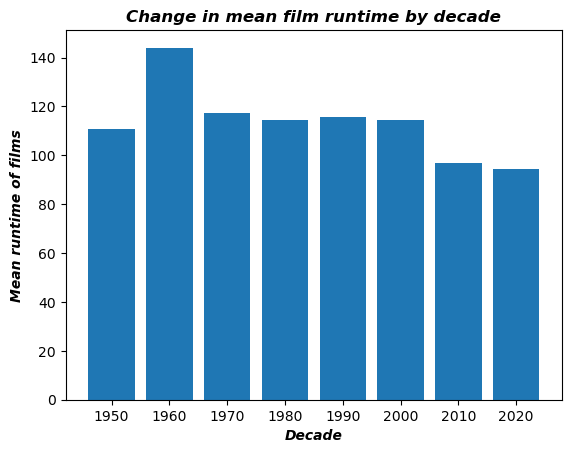

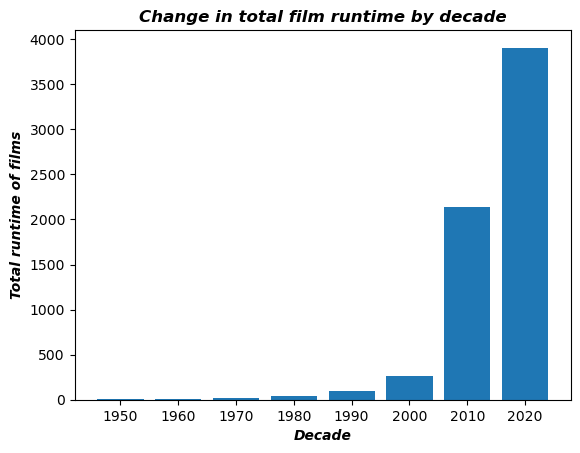

In [37]:
####film runtime by decade graphs:
##mean film runtime graph:
plt.figure() 
plt.bar(byYearMean.index, byYearMean, width = 8)
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Mean runtime of films', fontstyle = 'italic', weight = 'bold')
plt.title("Change in mean film runtime by decade", fontstyle = 'italic', weight = 'bold')
plt.savefig("meanRuntimeByDecadeFilm.png")

##total film runtime graph:
plt.figure()
plt.bar(byYearCount.index, byYearCount, width = 8)
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Total runtime of films', fontstyle = 'italic', weight = 'bold')
plt.title("Change in total film runtime by decade", fontstyle = 'italic', weight = 'bold')
plt.savefig("TotalRuntimeByDecadeFilm.png")

In [38]:
#find correlation coefficient (2 ways, to confirm correctness):
correlation = pd.DataFrame({'runtime':byYearMean, 'year':byYearMean.index})
corr = correlation["runtime"].corr(correlation["year"])
corr2 = correlation.corr(method='pearson')
print(corr)
print(corr2)

-0.6906337463355325
          runtime      year
runtime  1.000000 -0.690634
year    -0.690634  1.000000


<Figure size 640x480 with 0 Axes>

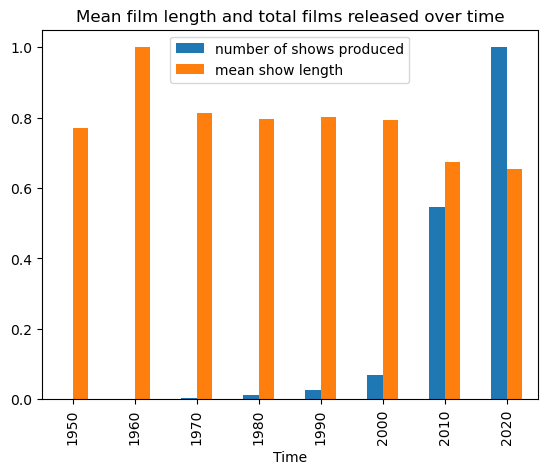

In [39]:
#hypothesis: perhaps more films = less time for each film to be produced?
#So plot runtime against number of films produced

#normalise count and mean so that we can see changes relative to their size.
countNormalised = byYearCount.divide(byYearCount.max())
meanNormalised = byYearMean.divide(byYearMean.max())

plottingDF = pd.DataFrame({'index':byYearMean.index, 'number of shows produced':countNormalised, 'mean show length':meanNormalised})
plt.figure()
plottingDF.plot(x = "index", y = ["number of shows produced", "mean show length"], kind = "bar", title="Mean film length and total films released over time", xlabel="Time")
plt.savefig("numberOfFilmsReleasedAndTheirRuntimeByDecade.png")

In [40]:
##Now calculate correlation for mean film length vs. number of films released.
lengthVsnumber = pd.DataFrame({'runtime':byYearMean, 'number':byYearCount})
corrLVN = lengthVsnumber["runtime"].corr(lengthVsnumber["number"])
corr2LVN = lengthVsnumber.corr(method='pearson')
print(corrLVN)
print(corr2LVN)

-0.7132762857923468
          runtime    number
runtime  1.000000 -0.713276
number  -0.713276  1.000000


## TV Show Code: ##

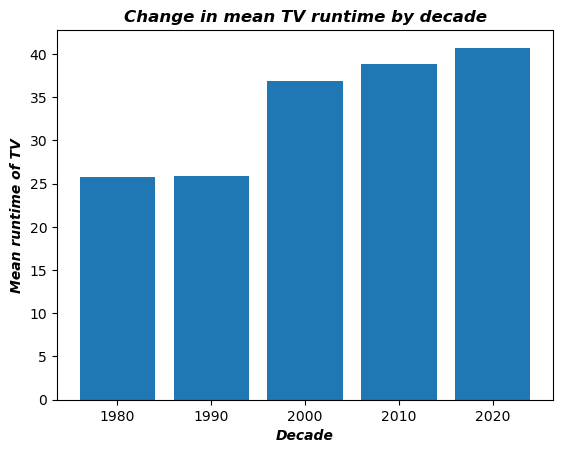

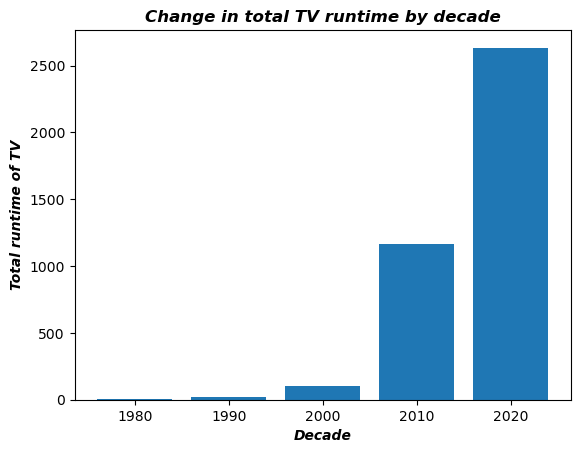

In [42]:
####TV runtime by decade graphs
##Mean runtime
plt.figure()
plt.bar(byYearMeanTV.index, byYearMeanTV, width = 8)
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Mean runtime of TV', fontstyle = 'italic', weight = 'bold')
plt.title("Change in mean TV runtime by decade", fontstyle = 'italic', weight = 'bold')
plt.savefig("meanRuntimeByDecadeTV.png")
##Total runtime
plt.figure()
plt.bar(byYearCountTV.index, byYearCountTV, width = 8)
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Total runtime of TV', fontstyle = 'italic', weight = 'bold')
plt.title("Change in total TV runtime by decade", fontstyle = 'italic', weight = 'bold')
plt.savefig("TotalRuntimeByDecadeTV.png")

In [43]:
#Find correlation (2 ways again):
correlationTV = pd.DataFrame({'runtime':byYearMeanTV, 'year':byYearMeanTV.index})
corrTV = correlationTV["runtime"].corr(correlationTV["year"])
corr2TV = correlationTV.corr(method='pearson')
print(corrTV)
print(corr2TV)

0.9358781518152478
          runtime      year
runtime  1.000000  0.935878
year     0.935878  1.000000


# Production Country Analysis #


## Impute missing values ##

In [27]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

titles = pd.read_csv('titles.csv')
df = titles.dropna(subset=['title'])
df["release_decade"] = df["release_year"].floordiv(10).multiply(10)
decades = set(df['release_decade'].unique());
decades = sorted(decades)


#quick look at missing values + their quantities
missingValues = df.loc[df["production_countries"] == "[]"]
print(len(missingValues))
print(len(df))
#Not a huge number are missing, but they are still worth imputing.
#It seems likely that they will be missing more in smaller production countries, so impute proportionally
print(df["production_countries"])

#Impute the data:
##Doesn't seem reasonable to impute data without considering time factor, as 
##presumably many more companies are getting into film in later years.

#replace data for proportion of countries of film in that decade.
for decade in decades:
    decadeDF = df.loc[df['release_decade'] == decade]
    #replace values with ones .isna can pick up, and find values that are and arent missing.
    decadeDF.replace("[]", inplace = True, regex=False, value= np.NaN)
    isMissingIndices = decadeDF['production_countries'].index[decadeDF['production_countries'].isna()].array
    notMissing = decadeDF['production_countries'].dropna(inplace=False).array

    #if there are values to replace, replace these.
    if (len(isMissingIndices) > 0):
         replacementValues = pd.Series(notMissing[:len(isMissingIndices)], index=isMissingIndices)
         df['production_countries'].loc[isMissingIndices] = replacementValues;
 

print(df["production_countries"])


228
5849
0             ['US']
1             ['US']
2             ['US']
3             ['GB']
4       ['GB', 'US']
            ...     
5845          ['NG']
5846              []
5847          ['CO']
5848          ['US']
5849              []
Name: production_countries, Length: 5849, dtype: object
0             ['US']
1             ['US']
2             ['US']
3             ['GB']
4       ['GB', 'US']
            ...     
5845          ['NG']
5846          ['JP']
5847          ['CO']
5848          ['US']
5849          ['US']
Name: production_countries, Length: 5849, dtype: object


## Find split of countries on all films produced ##

In [28]:
#split arrays into single values, and create counts of each country.
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else[])
df_exploded = df.explode('production_countries')
country_counts = df_exploded['production_countries'].value_counts().to_dict()

#function to replace countries with top country
def replace_countries(countries):
    if len(countries) > 1:
        most_common_country = max(country_counts, key=country_counts.get)
        return [most_common_country]
    else:
        return countries
#replace countries with top country
df['production_countries'] = df['production_countries'].apply(replace_countries)
#get count of films produced by each production country
country_counts = df['production_countries'].value_counts()

#for top 10 countries, get their production counts.
top = 10
other_countries = country_counts.iloc[top:].index.tolist()
df['production_countries'] = df['production_countries'].apply(lambda x: 'Others' if x in other_countries else x)
country_counts = df['production_countries'].value_counts()
df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,release_decade
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],[US],1.0,NaN,NaN,NaN,0.600,NaN,1940
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",[US],NaN,tt0075314,8.2,808582.0,40.965,8.179,1970
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",[US],NaN,tt0068473,7.7,107673.0,10.010,7.300,1970
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",[GB],NaN,tt0071853,8.2,534486.0,15.461,7.811,1970
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']",[US],NaN,tt0061578,7.7,72662.0,20.398,7.600,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",Others,NaN,tt13857480,6.8,45.0,1.466,NaN,2020
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,['drama'],[JP],NaN,tt11803618,7.7,348.0,NaN,NaN,2020
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,['comedy'],Others,NaN,tt14585902,3.8,68.0,26.005,6.300,2020
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],[US],NaN,NaN,NaN,NaN,1.296,10.000,2020


In [29]:
df_exploded = df.explode('production_countries')
production_countries_counts = df_exploded['production_countries'].value_counts()
print(production_countries_counts)

US        2732
Others    1172
IN         617
JP         276
KR         233
GB         232
ES         161
FR         127
CA         109
MX         100
BR          90
Name: production_countries, dtype: int64


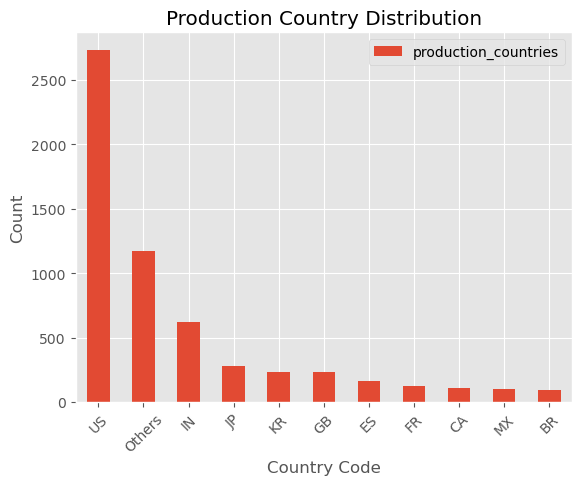

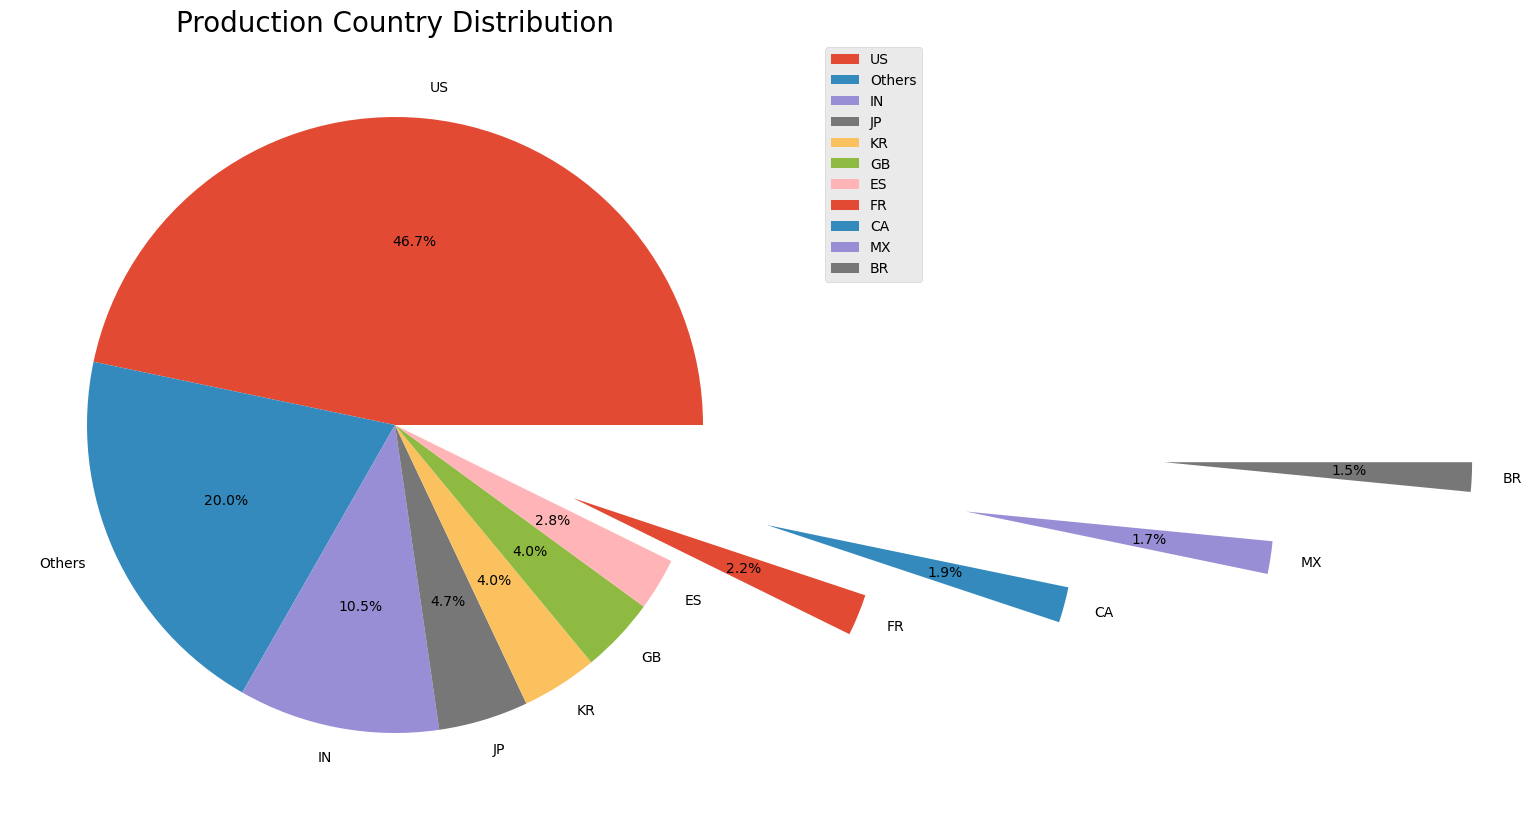

In [30]:
#bar chart of data
plt.figure()
plt.style.use('ggplot')
production_countries_counts.plot(kind='bar')
plt.title('Production Country Distribution')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()
#pie chart of data
plt.figure(figsize=(15,10))
explode = np.hstack((np.zeros(6), np.linspace(0,2.5,len(production_countries_counts)-6)))
plt.pie(production_countries_counts, labels=production_countries_counts.index, autopct='%1.1f%%', textprops={'fontsize':10}, explode=explode)
plt.title('Production Country Distribution', size=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Data per decade

/tmp/ipykernel_30/3390273220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else[])
/tmp/ipykernel_30/3390273220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["release_decade"] = df["release_year"].floordiv(10).multiply(10)
/tmp/ipykernel_30/3390273220.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

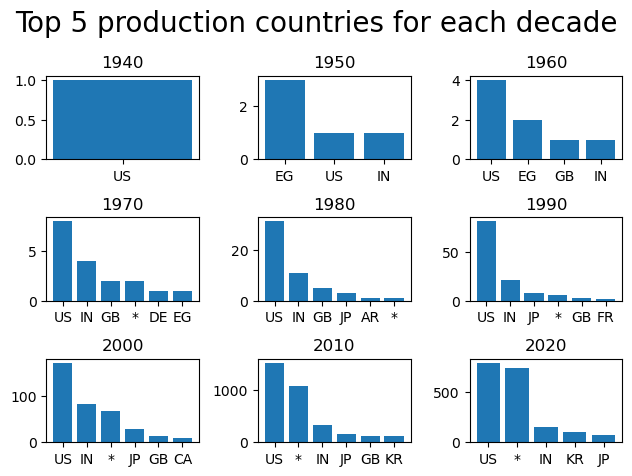

In [5]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
#general data processing
titles = pd.read_csv('titles.csv')
df = titles.dropna(subset=['title'])
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else[])
#get set of decades for which to do the same process as above.
df["release_decade"] = df["release_year"].floordiv(10).multiply(10)
decades = set(df['release_decade'].unique());
decades = sorted(decades)
country_counts = dict()

#add the production counts to the country_counts dict for each decade.
for decade in decades:
     decadeDF = df.loc[df['release_decade'] == decade]
     df_exploded = decadeDF.explode('production_countries')
     country_counts[decade] = df_exploded['production_countries'].value_counts().to_dict()

#replace multiple countries with the best country for the given decade.
def replace_countries(countries, decade):
    if len(countries) > 1:
        most_common_country = max(country_counts[decade], key=country_counts[decade].get)
        return [most_common_country]
    else:
        return countries
    

#replace each value with the most common one for each decade.
for i in range(len(df['release_decade'])):
    df['production_countries'].iloc[i] = replace_countries(df['production_countries'].iloc[i], df['release_decade'].iloc[i])



top5, axisT5 = plt.subplots(3,3)
i = 0; j = 0;



#now create the subplots
for decade in decades:
    decade_df = df.loc[df['release_decade'] == decade]
    country_counts = decade_df['production_countries'].value_counts()

    #Find the top 5 countries
    top = 5
    not_top_5_countries = country_counts.iloc[top:].index.tolist()
    top_5_data = decade_df
    top_5_data['production_countries'] = top_5_data['production_countries'].apply(lambda x: '*' if x in not_top_5_countries else x)
    top_country_counts = top_5_data['production_countries'].value_counts()

    top_5_exploded = top_5_data.explode('production_countries')
    top_5_counts = top_5_exploded['production_countries'].value_counts()


    #plot the country
    axisT5[i,j].bar(x = top_5_counts.index, height = top_5_counts)
    axisT5[i,j].set_title(decade)


    #shift along to next plot.
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
    

#apply titles to plot and show plot.
top5.suptitle('Top 5 production countries for each decade', fontsize = 20)
top5.tight_layout(pad = 1.0)
plt.show()

/tmp/ipykernel_30/671805808.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allCountriesDf = allCountriesDf.append(newDF)
/tmp/ipykernel_30/671805808.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allCountriesDf = allCountriesDf.append(newDF)
/tmp/ipykernel_30/671805808.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allCountriesDf = allCountriesDf.append(newDF)
/tmp/ipykernel_30/671805808.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allCountriesDf = allCountriesDf.append(newDF)
/tmp/ipykernel_30/671805808.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

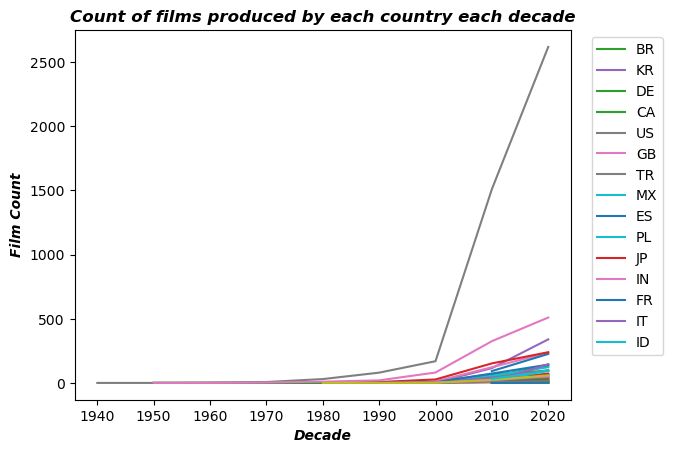

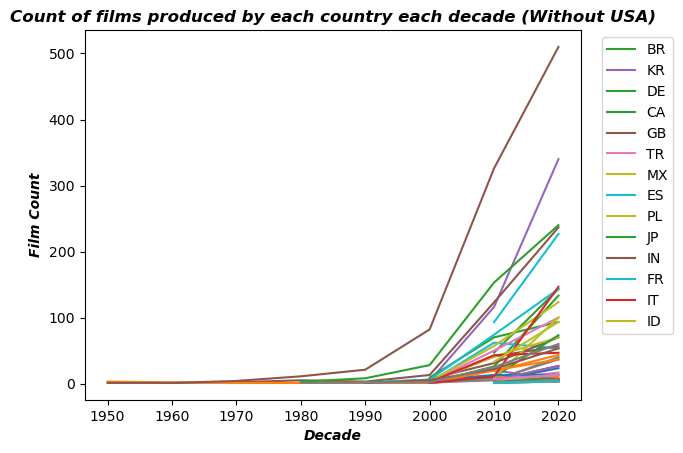

In [85]:
allCountriesDf = pd.DataFrame(data=None)

for decade in decades:

    decade_df = df.loc[df['release_decade'] == decade]
    country_counts = decade_df['production_countries'].value_counts()
    #split each value out of array.
    df_exploded = decade_df.explode('production_countries')
    countryCounts = df_exploded['production_countries'].value_counts()

    #add each country to our df for plotting
    for country in countryCounts.index:
        #only third of the way through 2020 decade so adjust for this.
        if (decade == 2020):
            countryCounts[country] = countryCounts[country]*3.333
        newDF = pd.DataFrame({"decade":decade, "country":country, "numFilms":countryCounts[country]}, index=([0]))
        allCountriesDf = allCountriesDf.append(newDF)



countries = set(allCountriesDf["country"].unique())

#we only want to plot top 15 or so labels (there are 50, and it gets several times longer than the graph)
topNcountries = countryCounts.iloc[:15].index

plt.figure()
for country in countries:
    #if plot is in the top N, show label for it, otherwise don't.
    if (country in topNcountries):
        plt.plot(allCountriesDf.loc[allCountriesDf["country"] == country]["decade"], allCountriesDf.loc[allCountriesDf["country"] == country]["numFilms"], label = country)
    else:
        plt.plot(allCountriesDf.loc[allCountriesDf["country"] == country]["decade"], allCountriesDf.loc[allCountriesDf["country"] == country]["numFilms"])
#show final plot
plt.show
plt.title('Count of films produced by each country each decade', fontstyle = 'italic', weight = 'bold')
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Film Count', fontstyle = 'italic', weight = 'bold')
plt.legend(bbox_to_anchor=(1.2, 1))

#now do identical report without the USA
countries.remove("US")
#plot all countries again
plt.figure()
#plot each country
for country in countries:
    #if plot is in the top N, show label for it, otherwise don't.
    if (country in topNcountries):
        plt.plot(allCountriesDf.loc[allCountriesDf["country"] == country]["decade"], allCountriesDf.loc[allCountriesDf["country"] == country]["numFilms"], label = country)
    else:
        plt.plot(allCountriesDf.loc[allCountriesDf["country"] == country]["decade"], allCountriesDf.loc[allCountriesDf["country"] == country]["numFilms"])
#show final plot
plt.show
plt.title('Count of films produced by each country each decade (Without USA)', fontstyle = 'italic', weight = 'bold')
plt.xlabel('Decade', fontstyle = 'italic', weight = 'bold')
plt.ylabel('Film Count', fontstyle = 'italic', weight = 'bold')
plt.legend(bbox_to_anchor=(1.2, 1))







# Score and Viewership Analysis #

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

## Load Dataset ##

In [36]:
# read the csv data 
titles = pd.read_csv('titles.csv')

In [37]:
titles

## Title check missing value ##

In [38]:
# Checking the missing value
missing_values = titles.isna().sum()
print(missing_values)

## Missing Data Imputation ##

In [39]:
# Drop the title
df = titles.dropna(subset=['title'])
df

In [40]:
# fulfill the sore data with their mean value
imdb_score_mean = df['imdb_score'].mean()
imdb_votes_mean = df['imdb_votes'].mean()
tmdb_popularity_mean = df['tmdb_popularity'].mean()
tmdb_score_mean = df['tmdb_score'].mean()

df['imdb_score'].fillna(imdb_score_mean, inplace=True)
df['imdb_votes'].fillna(imdb_votes_mean, inplace=True)
df['tmdb_popularity'].fillna(tmdb_popularity_mean, inplace=True)
df['tmdb_score'].fillna(tmdb_score_mean, inplace=True)

In [41]:
df.isna().sum()

## Deal with Genres and Production countries ##

In [42]:
import ast
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else[])

In [43]:
df['genres']

In [44]:
# one hot encoding
genres_dummies = pd.get_dummies(df['genres'].explode(), prefix = 'genre')
genres_dummies = genres_dummies.groupby(level=0).sum()

df_encoded = pd.concat([df, genres_dummies], axis = 1)

df_encoded

In [45]:
# count the value of genres
df_exploded = df_encoded.explode('genres')
genres_counts = df_exploded['genres'].value_counts()
print(genres_counts)

In [46]:
# count the value of age_certification
df_encoded['age_certification'].value_counts()

In [47]:
# count the value of seasons
df_encoded['seasons'].value_counts()

In [48]:
# Check the columns
df_encoded.columns

In [49]:
# Drop Columns
columns_to_drop = ['seasons', 'age_certification', 'genres','imdb_id']

df_cleaned = df_encoded.drop(columns=columns_to_drop)

In [50]:
df_cleaned.isna().sum()

In [51]:
df_cleaned.head()

## Analysis on Features ##

In [52]:
# Create the graph for type
type_counts = df_cleaned['type'].value_counts()

plt.figure(figsize=(10,6))
plt.style.use('ggplot')
type_counts.plot(kind='bar')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [53]:
# Create the graph for release year
year_counts = df['release_year'].value_counts().sort_index()
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('Count of Release Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [54]:
# Create the graph for runtime
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df['runtime'], bins=20, kde=True)
plt.title('Runtime Histogram')
plt.xlabel('Runtime')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df['runtime'])
plt.title('Runtime Boxplot')
plt.ylabel('Runtime')


plt.tight_layout()
plt.show()


In [55]:
# Create the graph for runtime
# Make sure we didn't include the runtime which equal to 0
df_cleaned = df_cleaned[df_cleaned['runtime'] != 0]

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

sns.histplot(df_cleaned['runtime'], bins=20, kde=True)
plt.title('Runtime Histogram')
plt.xlabel('Runtime')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['runtime'])
plt.title('Runtime Boxplot')
plt.ylabel('Runtime')


plt.tight_layout()
plt.show()


In [56]:
# Create the graph for genre
plt.figure()
plt.style.use('ggplot')
genres_counts.plot(kind='bar')
plt.title('Genres Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=30, horizontalalignment = 'right')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,10))
explode = np.hstack((np.zeros(6), np.linspace(0,2.5,len(genres_counts)-6)))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', textprops={'fontsize':10}, explode=explode)
plt.title('Genres Count', size=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [57]:
# Create the graph for tmdb_score
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['imdb_score'], bins=20, kde=True)
plt.title('IMDB Score Histogram')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['imdb_score'])
plt.title('IMDB Score Boxplot')
plt.ylabel('IMDB Score')


plt.tight_layout()
plt.show()

In [58]:
# Create the graph for tmdb_score
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['tmdb_score'], bins=20, kde=True)
plt.title('TMDB Score Histogram')
plt.xlabel('TMDB Score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['tmdb_score'])
plt.title('TMDB Score Boxplot')
plt.ylabel('TMDB Score')


plt.tight_layout()
plt.show()

In [59]:
# Create the graph for imdb_votes
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['imdb_votes'], bins=20, kde=True)
plt.title('IMDB Votes Histogram')
plt.xlabel('IMDB Votes')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['imdb_votes'])
plt.title('IMDB Votes Boxplot')
plt.ylabel('IMDB Votes')


plt.tight_layout()
plt.show()

In [0]:
# Create the graph for imdb_votes
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['imdb_votes'], bins=20, kde=True)
plt.title('IMDB Votes Histogram')
plt.xlabel('IMDB Votes')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['imdb_votes'])
plt.title('IMDB Votes Boxplot')
plt.ylabel('IMDB Votes')


plt.tight_layout()
plt.show()

In [60]:
# Create the graph for imdb_votes
df_cleaned['imdb_votes'] = np.log(df_cleaned['imdb_votes'])

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['imdb_votes'], bins=20, kde=True)
plt.title('IMDB Votes Histogram')
plt.xlabel('IMDB Votes')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['imdb_votes'])
plt.title('IMDB Votes Boxplot')
plt.ylabel('IMDB Votes')


plt.tight_layout()
plt.show()

In [0]:
# Create the tmdb_popularity
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['tmdb_popularity'], bins=20, kde=True)
plt.title('TMDB popularity Histogram')
plt.xlabel('TMDB popularity')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['tmdb_popularity'])
plt.title('TMDB popularity Boxplot')
plt.ylabel('TMDB popularity')


plt.tight_layout()
plt.show()

In [0]:
# Create the tmdb_popularity
df_cleaned['tmdb_popularity'] = np.log(df_cleaned['tmdb_popularity'])

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['tmdb_popularity'], bins=20, kde=True)
plt.title('TMDB popularity Histogram')
plt.xlabel('TMDB popularity')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['tmdb_popularity'])
plt.title('TMDB popularity Boxplot')
plt.ylabel('TMDB popularity')


plt.tight_layout()
plt.show()

## Score ##

In [0]:
print(df_cleaned.columns)

In [0]:
# Extract columns
release_years = df_cleaned['release_year']
imdb_scores = df_cleaned['imdb_score']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(release_years, imdb_scores, alpha=0.5, color='blue')
plt.title('IMDB Score vs Release Year')
plt.xlabel('Release Year')
plt.ylabel('IMDB Score')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [0]:
# Extract columns
release_years = df_cleaned['release_year']
imdb_scores = df_cleaned['tmdb_score']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(release_years, imdb_scores, alpha=0.5, color='blue')
plt.title('TMDB Score vs Release Year')
plt.xlabel('Release Year')
plt.ylabel('TMDB Score')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Lebal Encoding For Categorical Data ##

In [48]:
# Tranform the categorical data to numerical data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_cleaned['type'] = label_encoder.fit_transform(df_cleaned['type'])

df_cleaned['production_countries'] = label_encoder.fit_transform(df_cleaned['production_countries'].astype(str))

## Standard Scalar For Numerical ##

In [49]:
# Make all the variables reasonable following the standard scalar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_scale = ['release_year', 'runtime', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score']

df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

In [50]:
# Create the correlation matrix
correlation_matrix = df_cleaned[columns_to_scale].corr()
correlation_matrix

In [51]:
# Print the correlation heatmap
plt.figure(figsize=(10,8))
print(sns.__version__)
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Final Dataset ##

In [52]:
# Choose the Features
df_selected = df_cleaned[['type', 'release_year', 'runtime','production_countries','scoreindex', 'genre_action', 'genre_animation',
                     'genre_comedy', 'genre_crime', 'genre_documentation', 'genre_drama',
                     'genre_european', 'genre_family', 'genre_fantasy', 'genre_history',
                     'genre_horror', 'genre_music', 'genre_reality', 'genre_romance',
                     'genre_scifi', 'genre_sport', 'genre_thriller', 'genre_war',
                     'genre_western']]

In [53]:
# Print the selected data
df_selected

## Regression Task ##

In [141]:
# Load the package for machine learning 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [0]:
import statsmodels.api as sm
X = df_selected.drop(columns=['scoreindex'])
y = df_selected['scoreindex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Create the linear regression
linear_reg = LinearRegression()
linear_scores = cross_val_score(linear_reg, X, y, cv=5, scoring='neg_mean_squared_error')
linear_r2_scores = cross_val_score(linear_reg, X, y, cv=5, scoring='r2')
linear_rmse_scores = (-linear_scores) ** 0.5

# Create the randomforest regression
ranf_reg = RandomForestRegressor(n_estimators=100, random_state=30)
ranf_scores = cross_val_score(ranf_reg, X, y, cv=5, scoring='neg_mean_squared_error')
ranf_r2_scores = cross_val_score(ranf_reg, X, y, cv=5, scoring='r2')
ranf_rmse_scores = (-ranf_scores) ** 0.5

# Print the result of Liner regression
result_r2 = []
result_mse = []
max_len = len(list(X_train.columns.values))
for i in range(11):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    model = model.get_robustcov_results(cov_type='HC1', use_t=None)
    #display(model.summary())

    r2 = model.rsquared
    mse = model.mse_resid

    result_r2.append(r2)
    result_mse.append(mse)

    p_list = list(model.pvalues)[1:]
    #print(p_list)
    max_p_value = max(p_list)
    max_index = p_list.index(max_p_value)
    #display(max_p_value, max_index)
    feature_names = list(X_train.columns.values)
    X_train = X_train.drop(feature_names[max_index+1], axis = 1)
    X_test = X_test.drop(feature_names[max_index+1], axis = 1)

# Display the linear regression  
display(model.summary())



In [0]:
# Create the result
print(f"Linear Regression Cross-Validation RMSE Scores: {linear_rmse_scores}")
print(f"Linear Regression Mean RMSE: {linear_rmse_scores.mean()}")
print(f"Linear Regression Cross-Validation R^2 Scores: {linear_r2_scores}")
print(f"Linear Regression Mean R^2 Scores: {linear_r2_scores.mean()}")

print("\n\n")

print(f"Random Forest Regression Cross-Validation RMSE Scores: {ranf_rmse_scores}")
print(f"Random Forest Regression Mean RMSE: {ranf_rmse_scores.mean()}")
print(f"Random Forest Regression Cross-Validation R^2 Scores: {ranf_r2_scores}")
print(f"Random Forest Regression Mean R^2 Scores: {ranf_r2_scores.mean()}")

In [56]:
# Create the feature importance
ranf_reg.fit(X,y)
feature_importances = ranf_reg.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

# Plot the feature importance graph
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

## Supervised Learning Classification Task ##

In [57]:
# cut the target variable to 5 groups
df_selected['scoreindex'] = pd.qcut(df_selected['scoreindex'], q=5, labels=[1,2,3,4,5])

In [58]:
# dispaly the data
df_selected['scoreindex']

In [59]:
import matplotlib.pyplot as plt
from importlib import reload

plt=reload(plt)

# Supervised machine learning
X = df_selected.drop(columns='scoreindex')
y = df_selected['scoreindex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_classifier = DecisionTreeClassifier(random_state = 42)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zero-R baseline model
baseline_classifier = DummyClassifier(strategy = 'most_frequent')
baseline_classifier.fit(X_train, y_train)
baseline_prediction = baseline_classifier.predict(X_test)

# Create the confusion matrix to evaluate the model
tree_confusion_matrix = confusion_matrix(y_test, y_pred)
tree_classification_report = classification_report(y_test, y_pred)

# Create the confusion matrix to evaluate the model
baseline_confusion_matrix = confusion_matrix(y_test, baseline_prediction)
baseline_classification_report = classification_report(y_test, baseline_prediction)

# Create the graph
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(tree_confusion_matrix,xticklabels=['1','2','3', '4','5'], yticklabels=['1','2','3', '4','5'], annot=True, cmap='RdBu_r', fmt='d', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Prediction Labels')
plt.ylabel('True Labels')

# Create the graph
plt.subplot(1,2,2)
sns.heatmap(baseline_confusion_matrix, annot=True, cmap='RdBu_r', fmt='d', cbar=False)
plt.title('0R Baseline Confusion Matrix')
plt.xlabel('Prediction Labels')
plt.ylabel('True Labels')

plt.show()

# Printing accuracy Report
print("Decision Tree Classificaton Report:")
print(tree_classification_report)
print("0R Baseline Classificaton Report:")
print(baseline_classification_report)


## Unsupervised Learning Using clustering method to create label ##

In [48]:
# Using kmeans to create 5 labels
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X = df_selected.drop(columns=['scoreindex'])
kmeans.fit(X)

cluster_labels =kmeans.labels_

y_cluster =cluster_labels

In [47]:
# Unsupervised learning model
X_train, X_test, y_train, y_test = train_test_split(X, y_cluster, test_size=0.2, random_state=42)
dt_cluster = DecisionTreeClassifier(random_state = 42)
dt_cluster.fit(X_train, y_train)
dt_prediction = dt_cluster.predict(X_test)

# Zero-R baeline model
baseline_classifier = DummyClassifier(strategy = 'most_frequent')
baseline_classifier.fit(X_train, y_train)
baseline_prediction = baseline_classifier.predict(X_test)

# Create the confusion matrix
dt_confusion_matrix = confusion_matrix(y_test, dt_prediction)
dt_classification_report = classification_report(y_test, dt_prediction)

# Create the confusion matrix
baseline1_confusion_matrix = confusion_matrix(y_test, baseline_prediction)
baseline1_classification_report = classification_report(y_test, baseline_prediction)

# Print the graph
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(dt_confusion_matrix, xticklabels=['1','2','3', '4','5'], yticklabels=['1','2','3', '4','5'], annot=True, cmap='RdBu_r', fmt='d', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Prediction Labels')
plt.ylabel('True Labels')

# Print the graph
plt.subplot(1,2,2)
sns.heatmap(baseline1_confusion_matrix, xticklabels=['1','2','3', '4','5'], yticklabels=['1','2','3', '4','5'], annot=True, cmap='RdBu_r', fmt='d', cbar=False)
plt.title('0R Baseline Confusion Matrix')
plt.xlabel('Prediction Labels')
plt.ylabel('True Labels')

# Print the accuracy table 
print("Decision Tree Classificaton Report:")
print(dt_classification_report)
print("0R Baseline Classificaton Report:")
print(baseline1_classification_report)

In [0]:
# plot the decision tree
plt.figure(figsize=(50,20))
plot_tree(dt_cluster,
          feature_names=FEATURES,
          class_names=['1', '2', '3', '4', '5'],
          filled=True,
          fontsize=6)